In [173]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Preprocessing.preprocess import modified_z_score, fixer, baseline_als
import sklearn.linear_model as linear_model
from sklearn.decomposition import PCA

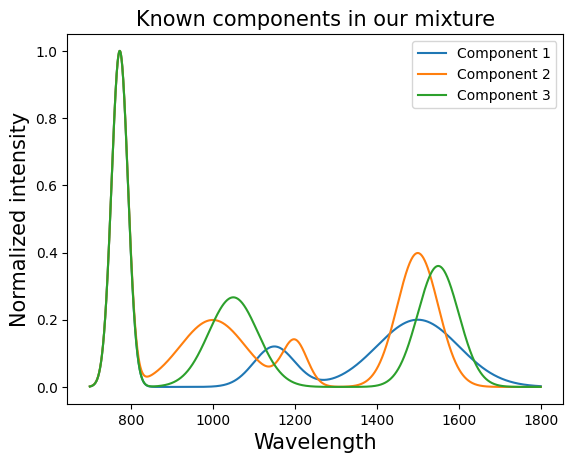

In [174]:

def Gauss(x, mu, sigma, A=1):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

x_range = np.linspace(700, 1800, 2000)
# First component
mu_a1 = 773
sigma_a1 = 20
intensity_a1 = 1

mu_a2 = 1150
sigma_a2 = 50
intensity_a2 = 0.3

mu_a3 = 1500
sigma_a3 = 100
intensity_a3 = 1

gauss_a = Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Second component
mu_b1 = 773
sigma_b1 = 20
intensity_b1 = 1

mu_b2 = 1000
sigma_b2 = 80
intensity_b2 = 0.8

mu_b3 = 1200
sigma_b3 = 30
intensity_b3 = 0.2

mu_b4 = 1500
sigma_b4 = 50
intensity_b4 = 1

gauss_b = Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3) + Gauss(x_range, mu_b4, sigma_b4, intensity_b4)

# Third component
mu_c1 = 773
sigma_c1 = 20
intensity_c1 = 1

mu_c2 = 1050
sigma_c2 = 60
intensity_c2 = 0.8

mu_c3 = 1550
sigma_c3 = 50
intensity_c3 = 0.9

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2) + Gauss(x_range, mu_c3, sigma_c3, intensity_c3)

# Normalization
component_a = gauss_a / np.max(gauss_a)
component_b = gauss_b / np.max(gauss_b)
component_c = gauss_c / np.max(gauss_c)


plt.plot(x_range, component_a, label = 'Component 1')
plt.plot(x_range, component_b, label = 'Component 2')
plt.plot(x_range, component_c, label = 'Component 3')
plt.title('Known components in our mixture', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Normalized intensity', fontsize = 15)
plt.legend()
plt.show()

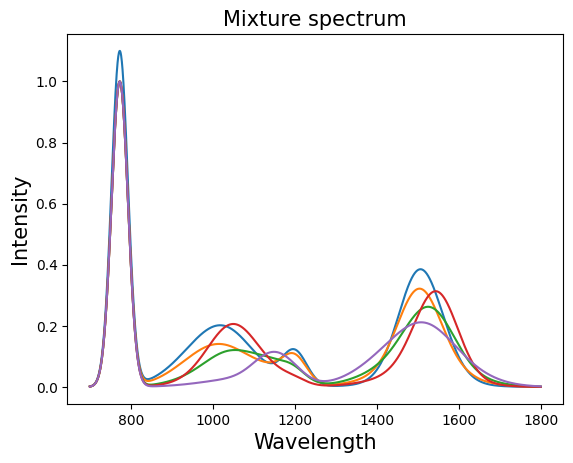

In [175]:
c_a = [0.1, 0.3, 0.5, 0.2, 0.9]
c_b = [0.8, 0.6, 0.2, 0.1, 0.05]
c_c = [0.2, 0.1, 0.3, 0.7, 0.05]

# Mixture
mixture = np.array([c_a, c_b, c_c]).T @ np.array([component_a, component_b, component_c])
# How does it look?
plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()


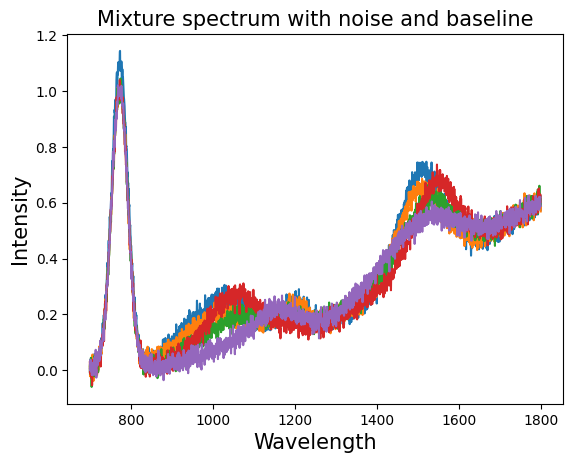

In [176]:
# Let's add some noise for a bit of realism:

# Random noise:
mixture += np.random.normal(0, 0.02, size = mixture.shape)

# Baseline:

# Baseline as a polynomial background:
poly = 0.001 * np.ones(len(x_range)) + 0.000001 * x_range + 0.0000005 * (x_range - 700)**2
mixture += poly


plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum with noise and baseline', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

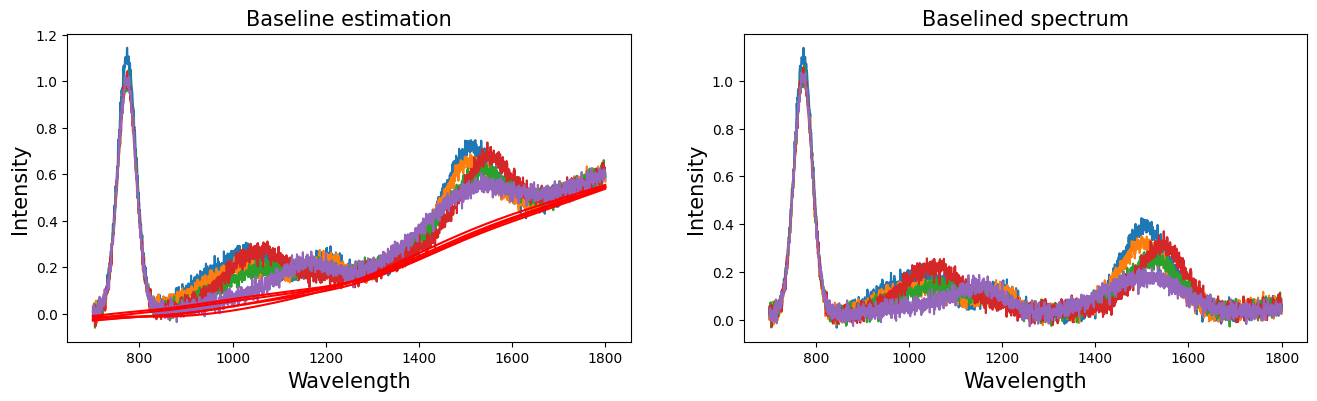

In [177]:
# Estimation of the baseline:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.0009 # asymmetry
estimated_baselined = []
for i in range(mixture.shape[0]):
    estimated_baselined.append(baseline_als(mixture[i], l, p))
estimated_baselined = np.array(estimated_baselined).T

# Baseline subtraction:
baselined_spectrum = mixture.T - estimated_baselined

# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(x_range, mixture.T)
ax1.plot(x_range, estimated_baselined, color = 'red')
ax1.set_title('Baseline estimation', fontsize = 15)
ax1.set_xlabel('Wavelength', fontsize = 15)
ax1.set_ylabel('Intensity',  fontsize = 15)


# We plot the mix spectrum after baseline subtraction
ax2.plot(x_range, baselined_spectrum )
ax2.set_title('Baselined spectrum', fontsize = 15)
ax2.set_xlabel('Wavelength', fontsize = 15)
ax2.set_ylabel('Intensity',  fontsize = 15)
plt.show()


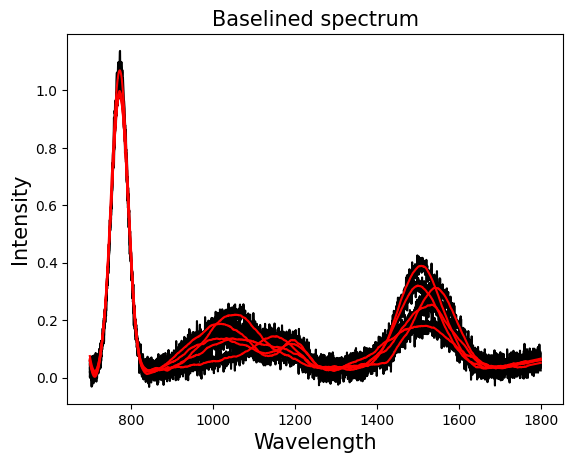

In [178]:
# Parameters:
w = 100 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = []
for i in range(baselined_spectrum.shape[1]):
    smoothed_spectrum.append(savgol_filter(baselined_spectrum[:,i], w, polyorder = p, deriv=0))
smoothed_spectrum = np.array(smoothed_spectrum)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/


# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
plt.plot(x_range, smoothed_spectrum.T, color = 'red', label = 'Baselined spectrum with noise' )
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [179]:
cov = np.cov(smoothed_spectrum.T)
cov.shape

(2000, 2000)

In [180]:
pca = PCA().fit(cov)

In [181]:
pca.explained_variance_ratio_

array([6.75356938e-01, 3.23559142e-01, 1.03534590e-03, ...,
       6.96123659e-34, 3.12726201e-34, 2.50111617e-35])

In [182]:
np.cumsum(pca.explained_variance_ratio_)

array([0.67535694, 0.99891608, 0.99995143, ..., 1.        , 1.        ,
       1.        ])

In [183]:
pca = PCA(n_components=3)
pca.fit(cov)

PCA(n_components=3)

In [184]:
pc_spectrum = pca.transform(smoothed_spectrum)

In [185]:
smoothed_spectrum.shape

(5, 2000)

In [186]:
pc_spectrum

array([[ 6.73546581,  0.04715282,  7.97121887],
       [ 5.53872409,  0.30520966,  7.38125827],
       [ 4.69522501, -0.50614285,  7.75557245],
       [ 5.29222606, -1.88412657,  7.6915653 ],
       [ 3.59080402,  0.20614164,  7.85363811]])

In [187]:
pc_spectrum.shape

(5, 3)

In [188]:
pc_spectrum.shape

(5, 3)

In [189]:
from sklearn.linear_model import LinearRegression
X = pc_spectrum
y = np.array([c_a, c_b, c_c]).T

reg = LinearRegression(fit_intercept=False).fit(X, y)

reg.score(X, y)

reg.coef_

array([[-0.25608592,  0.10809938,  0.22814276],
       [ 0.25110012,  0.18761837, -0.1137614 ],
       [ 0.03385414, -0.2816324 , -0.00107696]])

In [190]:
concentration_pred = reg.coef_ @ pc_spectrum.T
concentration = np.array([c_a, c_b, c_c]).T

In [191]:
concentration.T

array([[0.1 , 0.3 , 0.5 , 0.2 , 0.9 ],
       [0.8 , 0.6 , 0.2 , 0.1 , 0.05],
       [0.2 , 0.1 , 0.3 , 0.7 , 0.05]])

In [192]:
concentration_pred

array([[0.09881512, 0.29858437, 0.51228298, 0.19583746, 0.89448013],
       [0.79330596, 0.60833492, 0.20172506, 0.10037857, 0.04688639],
       [0.20615892, 0.09360246, 0.29314657, 0.70151132, 0.05504934]])